In [1]:
import numpy as np
from models import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import cv2
import time
import datetime
import argparse

from PIL import Image

import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
from utils.parse_config import *
from visualization import visualize

%matplotlib inline

batch_size = 1
checkpoint_model = None
class_path = "data/coco.names"
conf_thres = 0.8
image_folder = "data/samples/"
img_size = 416
model_def = "config/yolov3.cfg"
n_cpu = 0
nms_thres = 0.4
weights_path = "weights/yolov3.weights"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up model
model = Darknet(model_def, img_size=img_size).to(device)

if weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(weights_path))
print("Weight loaded")
print("Device:{}".format(device))
torch.cuda.empty_cache()

Weight loaded
Device:cuda


In [6]:
# 最初の設定
steps = 50
model.eval()

input_img = cv2.imread('data/samples/torres.png')
input_img = cv2.resize(input_img, (416, 416)) #Yolov3の入力用にリサイズ
input_img = input_img.astype(np.float32)
input_img = input_img[:, :, (2, 1, 0)]#要注意
# 真っ黒から徐々に元の画像に戻していく

In [18]:
stdev_spread = 0.15
n_samples = 25
magnitude = True
grid_num = 251
class_num = 5

In [42]:
x = input_img / 255.0
stdev = stdev_spread * (np.max(x) - np.min(x))
total_gradients = np.zeros_like(x)

for i in range(n_samples):
    noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
    x_plus_noise = x + noise
    x_plus_noise = np.transpose(x_plus_noise, (2, 0, 1))# (h, w, ch) => (ch, h, w)
    x_plus_noise = np.expand_dims(x_plus_noise, 0)
    x_plus_noise = np.array(x_plus_noise)
    x_plus_noise = torch.tensor(x_plus_noise, dtype=torch.float32, device='cuda', requires_grad=True)
    detections, layers = model(x_plus_noise)

    # 今回はクラスの信頼度のみで見ていくので、detections[0, grid_num, 5:]になる
    # Bboxも見れるIGの方がよいかも？
    # でもIG出すより手軽かつ高速に出力できる
    output = detections[0, grid_num, 5:]
    # one_hot:1つだけHigh（1）他はLow（0）
    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    # 人のクラスなので，0番目がHigh（1）
    one_hot[0][0] = 1
    one_hot = torch.tensor(one_hot, dtype=torch.float32, device='cuda', requires_grad=True)
    one_hot = torch.sum(one_hot * output)

    #####
    # よく考えてみると，見たいクラスの信頼度をbackwardしているだけなのでone_hot定義しなくてもよいのでは
    # 普通にクラスの信頼度をbackwardすれば済みそう
    #####

    if x_plus_noise.grad is not None:
        x_plus_noise.grad.data.zero_()
    model.zero_grad()
    one_hot.backward(retain_graph=True)
    grad = x_plus_noise.grad.data.cpu().numpy()[0]
    grad = np.transpose(grad, (1, 2, 0))
    if magnitude:
        total_gradients += (grad * grad)
    else:
        total_gradients += grad

avg_gradients = total_gradients / n_samples

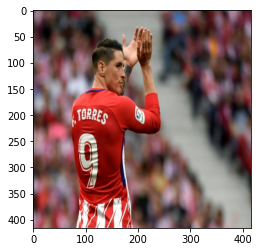

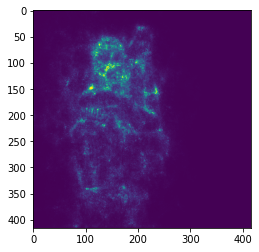

In [43]:
percentile = 99.9
img_2d = np.average(avg_gradients, axis = 2)
span = abs(np.percentile(img_2d, percentile))
vmin = -span
vmax = span
img_2d = np.clip((img_2d - vmin) / (vmax - vmin), -1, 1)
plt.figure()
plt.imshow(x)
plt.figure()
plt.imshow(img_2d)